In [1]:
class Node:
    def __init__(self, index):
        self.index = index
        self.left_child = None
        self.right_child = None
        self.left_bound = None
        self.right_bound = None

In [1]:
def build_tree(root, depth):
    root.index = 0
    current_nodes = [root]
    
    counter = 1

    for i in range(0, depth+1):
        
        print(i)
        print([n.index for n in current_nodes])
        
        prev_nodes = current_nodes.copy()
        
        for node in prev_nodes:
            node.left_child = Node(counter)
            counter += 1
            node.right_child = Node(counter)
            counter += 1
            current_nodes.pop()
            current_nodes.append(node.left_child)
            current_nodes.append(node.right_child)
        
    return(root)

In [3]:
depth = 2
root = Node(0)
min_val = 0
max_val = 1000
root.left_bound = min_val
root.right_bound = max_val
build_tree(root, depth)

In [4]:
cutpoints = [500, 250, 150, 275, 750, 600, 900]

In [5]:
def depth_first(root):
 
    if (root == None):
        return
 
    st = []
 
    # start from root node (set current node to root node)
    curr = root
 
    # run till stack is not empty or current is
    # not NULL
    while (len(st) or curr != None):
     
        # Print left children while exist
        # and keep appending right into the
        # stack.
        while (curr != None):
         
            print(curr.index, end = " ")
            cutpoints[curr.index] = cutpoints[curr.index] + 2
            print(f"index:\t{curr.index}\tLB:\t{curr.left_bound}\tRB:\t{curr.right_bound}")
    
            if (curr.right_child != None):
                st.append(curr.right_child)
                curr.right_child.left_bound = cutpoints[curr.index]
                curr.right_child.right_bound = curr.right_bound
 
            if (curr.left_child != None):
                curr.left_child.left_bound = curr.left_bound
                curr.left_child.right_bound = cutpoints[curr.index]

            curr = curr.left_child
            
         
        # We reach when curr is NULL, so We
        # take out a right child from stack
        if (len(st) > 0):
            curr = st[-1]
            st.pop()

In [6]:
depth_first(root)

0 index:	0	LB:	0	RB:	1000
1 index:	1	LB:	0	RB:	502
3 index:	3	LB:	0	RB:	252
4 index:	4	LB:	252	RB:	502
2 index:	2	LB:	502	RB:	1000
5 index:	5	LB:	502	RB:	152
6 index:	6	LB:	152	RB:	1000


In [7]:
from scipy.optimize import minimize
import scipy.stats
import torch
import torch.optim as optim
import scipy
# shifted and scaled sigmoid function
def test_sigmoid(x, a=0, b=1.):
    return 1 / (1 + (np.exp(-1 * (x - a) / b)))

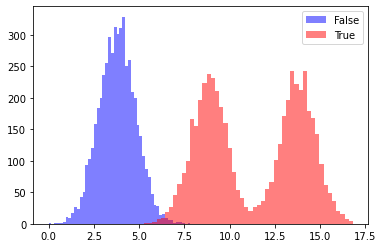

In [8]:
# from cutpoint_model import Model
import numpy as np
import matplotlib.pyplot as plt
from math import exp

N = 10000
P = 5

rs = np.random.RandomState(1978)

X = rs.randn(N, P)
w = rs.randn(P)

y_prob = test_sigmoid(X @ w)
y = (rs.rand(N) < y_prob).astype(int)
t = (rs.randn(N) + 5 * y + (rs.rand(N)> 0.5) * 5 * y )

# make times positive
t += abs(min(t))

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

In [13]:
# torch.autograd.set_detect_anomaly(True)
class Model:
    def __init__(self, X, t, sigmoid_temp = 0.01, depth = 1, cutpoint0=None):
        self.X = torch.tensor(X, dtype=torch.float)
        self.t = torch.tensor(t, dtype=torch.float)
        self.sigmoid_temp = sigmoid_temp 
        self.depth = depth

        self.n_cutpoints = 2**(depth+1)-1
        self.theta = [torch.zeros( X.shape[1]+1, requires_grad=True).float() for i in range(0,self.n_cutpoints)]
            
        self.cutpoint_logit = [torch.tensor(self.logit(torch.tensor(cutpoint)).item(), requires_grad=True) for cutpoint in cutpoint0]
    
        # set up cutpoint tree
        self.root = Node(0)
        root.left_bound = min(self.t)
        root.right_bound = max(self.t)
        self.root = build_tree(root, depth)
        
        
    def logit(self, x):
        return torch.log(x/ (1 - x))
    
    # shifted and scaled sigmoid function
    def sigmoid(self, x, a=0, b=1.):
        return 1 / (1 + (torch.exp(-1 * (x - a) / b)))
    
    
    def pred_value(self, x, theta):
        prod = torch.matmul(x,theta)
        return self.sigmoid(prod)
    
    
    def loss_func(self, params, x, t):

        theta = params[:-1][0]

        cutpoint_logit = params[-1]

        cutpoint = self.sigmoid(cutpoint_logit)

        left_boundary = self.sigmoid(t, 0, self.sigmoid_temp)
        right_boundary = -1 * self.sigmoid(t, 1, self.sigmoid_temp)
#                 right_boundary = -1 * self.sigmoid(t, c0, self.sigmoid_temp)

        t_disc = self.sigmoid(t, cutpoint, self.sigmoid_temp)
        
        
        x1 = torch.cat([x, torch.ones((len(x), 1))], axis=1)

        p_hat = self.pred_value(x1, theta)

        n = len(t)

        likelihood = (-1/n) * torch.sum( t_disc * right_boundary * torch.log(p_hat) + (1-t_disc) * left_boundary *torch.log(1-p_hat) )
        
        prior = -1 * scipy.stats.beta.logpdf(cutpoint.detach().numpy(), 1.5, 1.5)

#         print('Likelihood = %.7e | Prior = %.7e' % (likelihood, prior))

        return likelihood + prior
    
    
    def train(self):
#         optimizers = [optim.Adam([self.theta[i], self.cutpoint_logit[i]], lr=0.001) for i in range(0,self.n_cutpoints)] 
        # + is concatenateion of lists
        optimizer = optim.Adam(self.theta + self.cutpoint_logit, lr=0.001)
        loss = 0
        loss_list = [0 for i in range(0, self.n_cutpoints)]
        iteration_num = 1

        while iteration_num < 10:
            
#             # middle cutpoint
#             t_min = min(self.t)
#             t_max = max(self.t)
#             t_convert = (self.t - t_min) / (t_max-t_min)

#             optimizer0.zero_grad()
#             loss0 = self.loss_func((self.theta, self.cutpoint_logit0), self.X, t_convert)
#             loss0.backward(retain_graph=True)
#             optimizer0.step()
#             self.cutpoint0 = self.sigmoid(self.cutpoint_logit0) * (t_max-t_min) + t_min
            
            
#             # cutpoint left of middle
#             t_min = min(self.t)
#             t_max = self.cutpoint0
#             X = self.X[(t_min <= self.t) == (self.t <= t_max), :]
#             t = self.t[(t_min <= self.t) == (self.t <= t_max)]
#             t_convert = (t - t_min) / (t_max-t_min)
#             # impose sigmoid at boundary of unit interval
            
#             optimizer1.zero_grad()
#             loss1 = self.loss_func((self.theta, self.cutpoint_logit1), X, t_convert)
#             loss1.backward(retain_graph=True)
#             optimizer1.step()
#             self.cutpoint1 = self.sigmoid(self.cutpoint_logit1) * (t_max-t_min) + t_min
            
            
#             # cutpoint right of middle
#             t_min = self.cutpoint0
#             t_max = max(self.t)
#             X = self.X[(t_min <= self.t) == (self.t <= t_max), :]
#             t = self.t[(t_min <= self.t) == (self.t <= t_max)]
#             t_convert = (t - t_min) / (t_max-t_min)
            
#             optimizer2.zero_grad()
#             loss2 = self.loss_func((self.theta, self.cutpoint_logit2), X, t_convert)
#             loss2.backward(retain_graph=True)
#             optimizer2.step()
#             self.cutpoint2 = self.sigmoid(self.cutpoint_logit2) * (t_max-t_min) + t_min


            #####################################
            # depth first traversal

            st = []

            # start from root node (set current node to root node)
            curr = self.root

            # run till stack is not empty or current is
            # not NULL
            while (len(st) or curr != None):

                # Print left children while exist
                # and keep appending right into the
                # stack.
                while (curr != None):
                    t_min = curr.left_bound
                    t_max = curr.right_bound
                    X = self.X[(t_min <= self.t) == (self.t <= t_max), :]
                    t = self.t[(t_min <= self.t) == (self.t <= t_max)]
                    t_convert = (t - t_min) / (t_max-t_min)
                    
                    loss_list[curr.index] = self.loss_func((self.theta[curr.index], self.cutpoint_logit[curr.index]), X, t_convert)
                    self.cutpoint_logit[curr.index] = self.sigmoid(self.cutpoint_logit[curr.index]) * (t_max-t_min) + t_min
                    
                    print(f"index:\t{curr.index}\tLB:\t{curr.left_bound}\tvalue:\t{self.cutpoint_logit[curr.index]}\t\tRB:\t{curr.right_bound}")

                    if (curr.right_child != None):
                        st.append(curr.right_child)
                        curr.right_child.left_bound = self.cutpoint_logit[curr.index]
                        curr.right_child.right_bound = curr.right_bound

                    if (curr.left_child != None):
                        curr.left_child.left_bound = curr.left_bound
                        curr.left_child.right_bound = self.cutpoint_logit[curr.index]

                    curr = curr.left_child


                # We reach when curr is NULL, so We
                # take out a right child from stack
                if (len(st) > 0):
                    curr = st[-1]
                    st.pop()


            ###################################
            
            loss = sum(loss_list)
            loss.backward(retain_graph=True)
            optimizer.step()

            # one optimization step
            iteration_num += 1




In [16]:
depth = 2
cutpoint0 = [0.5 for i in range(0, 2**(depth+1) + -1)]

m = Model(X, t, depth = depth, cutpoint0=cutpoint0)


In [17]:
m.train()

index:	0	LB:	0.0	value:	8.402695655822754		RB:	16.805391311645508
index:	1	LB:	0.0	value:	4.201347827911377		RB:	8.402695655822754
index:	3	LB:	0.0	value:	2.1006739139556885		RB:	4.201347827911377
index:	4	LB:	4.201347827911377	value:	6.3020219802856445		RB:	8.402695655822754
index:	2	LB:	8.402695655822754	value:	12.604043960571289		RB:	16.805391311645508
index:	5	LB:	8.402695655822754	value:	10.50337028503418		RB:	12.604043960571289
index:	6	LB:	12.604043960571289	value:	14.704717636108398		RB:	16.805391311645508
index:	0	LB:	0.0	value:	16.801624298095703		RB:	16.805391311645508
index:	1	LB:	0.0	value:	16.55372428894043		RB:	16.801624298095703
index:	3	LB:	0.0	value:	14.748849868774414		RB:	16.55372428894043
index:	4	LB:	16.55372428894043	value:	16.801170349121094		RB:	16.801624298095703
index:	2	LB:	16.801624298095703	value:	16.805391311645508		RB:	16.805391311645508
index:	5	LB:	16.801624298095703	value:	16.805391311645508		RB:	16.805391311645508
index:	6	LB:	16.805391311645508	valu

In [285]:
m.cutpoint_logit

[tensor(16.8054, grad_fn=<AddBackward0>),
 tensor(16.8054, grad_fn=<AddBackward0>),
 tensor(16.8054, grad_fn=<AddBackward0>)]

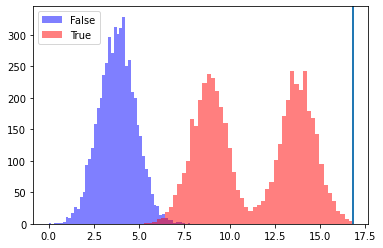

In [289]:
plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")


for cpi in m.cutpoint_logit:
    plt.axvline(cpi)

plt.legend()
plt.show()

[tensor([0., 0., 0., 0., 0., 0.], requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0.], requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0.], requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0.], requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0.], requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0.], requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)]